In [1]:
!pip install sentence-transformers

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
query_1 = "dog"

bing_search_results = [
    "Dog - Wikipedia",
    "Adopting a dog or puppy | RSPCA Australia",
    "dog | History, Domestication, Physical Traits, & Breeds",
    "New South Wales | Dogs & Puppies | Gumtree Australia Free",
    "dog - Wiktionary"
]


query_2 = "what is a dog"

google_search_results = [
    "Dog - Wikipedia",
    "Dog - Simple English Wikipedia, the free encyclopedia",
    "Dog | National Geographic",
    "dog | History, Domestication, Physical Traits, & Breeds",
    "What is a Dog | Facts About Dogs | DK Find Out"
]

In [4]:
# Relevance scores of the documents
relevance_grades = [
    [3.0, 2.0, 2.0, 2.0, 1.0],
    [3.0, 3.0, 1.0, 1.0, 0.0]
]

In [6]:
# Creates (q, d) tuple

def get_query_document_embedding(q, d):
  '''
  Returns a 5 x 768 dimension vector
  '''
  q = torch.tensor(model.encode(q))
  d_embed = torch.tensor(model.encode(d))
  q = q.unsqueeze(0).repeat(d_embed.shape[0], 1)
  return torch.cat((q, d_embed), dim = -1)

In [7]:
import numpy as np
dataset = []
dataset.extend(get_query_document_embedding(query_1, bing_search_results))
dataset.extend(get_query_document_embedding(query_2, google_search_results))

In [8]:
dataset = torch.from_numpy(np.array(dataset))

In [9]:
dataset.shape

torch.Size([10, 768])

In [10]:
relevance_grades = [grade for grades in relevance_grades for grade in grades]

In [11]:
relevance_grades

[3.0, 2.0, 2.0, 2.0, 1.0, 3.0, 3.0, 1.0, 1.0, 0.0]

In [12]:
from torch.utils.data import DataLoader

class customDataset:
  def __init__(self, query_doc, relevance):
    self.query_doc = query_doc
    self.relevance = relevance

  def __getitem__(self, idx):
    query_doc_vec = self.query_doc[idx]
    relevance = torch.tensor(self.relevance[idx])
    return query_doc_vec, relevance

  def __len__(self):
    return len(self.relevance)

train_dataset = customDataset(dataset, relevance_grades)
train_loader = DataLoader(train_dataset, batch_size = 5, shuffle=False)

In [13]:
class BasicNet(nn.Module):
  def __init__(self, d, output_class):
    super().__init__()
    self.linear1 = nn.Linear(d, 100)
    self.linear2 = nn.Linear(100, output_class)

  def forward(self, x):
    x = self.linear1(x)
    x = self.linear2(x)
    return x

  def kl_loss(self, p, q):
    p = F.softmax(p, dim = -1)
    q = F.softmax(q, dim = -1)
    return (p * (p / q).log()).sum()

In [14]:
net = BasicNet(768, 1)

In [15]:
net

BasicNet(
  (linear1): Linear(in_features=768, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=1, bias=True)
)

In [16]:
'''
Training Loop
'''

def train(train_loader, net, epochs):
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    total_iterations = 0

    for epoch in range(epochs):
        net.train()

        loss_sum = 0
        num_iterations = 0

        data_iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}')

        for data in data_iterator:
            x, y = data
            num_iterations += 1
            optimizer.zero_grad()
            output = net(x).view(-1)
            loss = net.kl_loss(y, output)
            loss_sum += loss.item()
            avg_loss = loss_sum / num_iterations
            data_iterator.set_postfix(loss=avg_loss)
            loss.backward()
            optimizer.step()

train(train_loader, net, epochs=50)

Epoch 50: 100%|██████████| 2/2 [00:00<00:00, 398.58it/s, loss=0.0101]


In [17]:
y_pred = []
for x, y in train_loader:
  y_pred.append(net(x).view(-1).detach().numpy())

In [20]:
import matplotlib.pyplot as plt

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def visualize(y):
  probs = softmax(y)
  x = [i for i in range(1, 6)]
  print(probs)
  plt.bar(x,probs)
  plt.title('Predicted')
  plt.show()


[0.44663322 0.16430718 0.16430718 0.16430718 0.06044523]


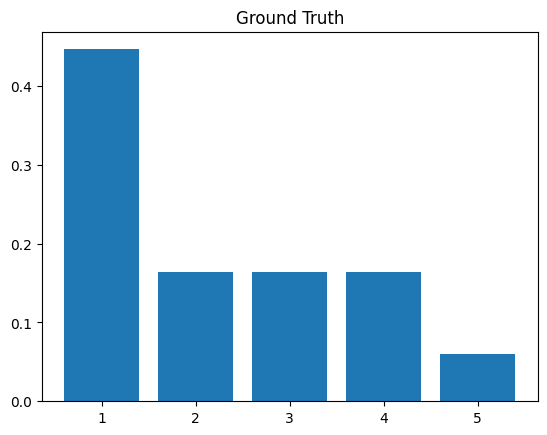

In [19]:
visualize(relevance_grades[:5])

[0.48846975 0.16362853 0.12215585 0.16420698 0.06153888]


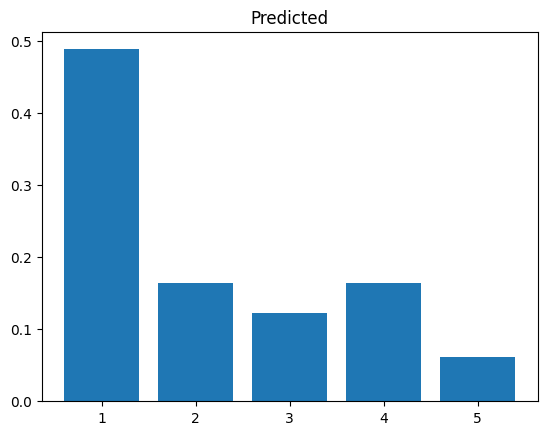

In [21]:
visualize(y_pred[0])